In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manimathavan","key":"a0cdb2f4933baaccd034340dbfad4395"}'}

In [3]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                                     title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                                     Online Food Dataset                                  3KB  2024-03-02 18:50:30          14953        307  0.9411765        
sukhmandeepsinghbrar/car-price-prediction-dataset                       Car Price Prediction Dataset                       141KB  2024-03-28 08:27:39            652         26  1.0              
prishasawhney/imdb-dataset-top-2000-movies                              IMDB Dataset (Top 2000 movies)                      75KB  2024-03-27 18:51:36            632         22  1.0              
syedanwarafridi/vehicle-s

In [5]:
! kaggle datasets download -d shravankumar9892/image-colorization

100% 2.10G/2.10G [00:27<00:00, 107MB/s]
100% 2.10G/2.10G [00:28<00:00, 80.6MB/s]


In [6]:
! unzip /content/image-colorization.zip

Archive:  /content/image-colorization.zip
  inflating: ab/ab/ab1.npy           
  inflating: ab/ab/ab2.npy           
  inflating: ab/ab/ab3.npy           
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: l/gray_scale.npy        


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, InputLayer, Conv2DTranspose, Dropout, BatchNormalization, Input, Concatenate, Activation, concatenate ,RepeatVector ,Reshape ,UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.transform import resize
from PIL import Image

import os

In [8]:
def compareImages(start, end, prediction, gray, color):
    for i in range(start,end):
        f, axarr = plt.subplots(1,3)
        axarr[0].title.set_text('Black and white')
        axarr[1].title.set_text('Prediction')
        axarr[2].title.set_text('original')
        axarr[0].imshow(gray[i], cmap='gray')
        axarr[1].imshow(prediction[i])
        axarr[2].imshow(color[i])

In [9]:
def plotLossAndAcc(history):
    _, subplots = plt.subplots(1,2)
    subplots[0].plot(history.history['acc'])
    subplots[0].set_title('Training Accuracy')
    subplots[0].set_ylabel('Accuracy')
    subplots[0].set_xlabel('epoch')

    subplots[1].plot(history.history['loss'])
    subplots[1].set_title('Training Loss')
    subplots[1].set_ylabel('Loss')
    subplots[1].set_xlabel('epoch')

In [10]:
init_images_gray = np.load("l/gray_scale.npy")
init_images_lab = np.load("ab/ab/ab1.npy")

In [11]:
amount = 2000
width = 224
height = 224

init_images_lab[0][0][0]

array([129, 136], dtype=uint8)

In [12]:
temp1_amount = int(amount)
temp1 = np.zeros((temp1_amount, width, height, 3));
temp1[:,:,:,0] = init_images_gray[0:temp1_amount]
temp1[:,:,:,1:] = init_images_lab[0:temp1_amount]
temp1 = temp1.astype("uint8")
temp1_rgb = []
temp1_gray = np.zeros((temp1_amount, width, height,3 ))

for i in range(0, 3):
    temp1_gray[:temp1_amount, :, :, i] = init_images_gray[:temp1_amount]

for i in range(0, temp1_amount):
    temp1_rgb.append(cv2.cvtColor(temp1[i], cv2.COLOR_LAB2RGB))

temp1_rgb = np.array(temp1_rgb)

In [13]:
images_rgb = temp1_rgb
images_gray = temp1_gray

In [14]:
model = Sequential()
model.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 12, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))
model.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 3, use_bias = True, bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05) , padding = "valid", activation = tf.nn.relu))

model.compile(optimizer = tf.keras.optimizers.Adam(epsilon = 1e-8), loss='mse', metrics=['acc'])

In [15]:
preprocessed_gray_images = preprocess_input(images_gray)
preprocessed_rgb_images = preprocess_input(images_rgb)

In [16]:
model1_checkpoint = ModelCheckpoint("./model_CNN_01.h5",
                            monitor = "loss",
                            mode="min",
                            save_best_only = True,
                            verbose = 1)

In [17]:
model1_history = model.fit(preprocessed_gray_images[:temp1_amount], preprocessed_rgb_images, shuffle=True, callbacks=[model1_checkpoint], epochs = 30, batch_size = 2)

Epoch 1/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3186 - acc: 0.5568
Epoch 1: loss improved from inf to 0.31860, saving model to ./model_CNN_01.h5
1000/1000 [==============================] - 218s 217ms/step - loss: 0.3186 - acc: 0.5568
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - ETA: 0s - loss: 0.3150 - acc: 0.5689
Epoch 2: loss improved from 0.31860 to 0.31505, saving model to ./model_CNN_01.h5
1000/1000 [==============================] - 211s 211ms/step - loss: 0.3150 - acc: 0.5689
Epoch 3/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3144 - acc: 0.5726
Epoch 3: loss improved from 0.31505 to 0.31441, saving model to ./model_CNN_01.h5
1000/1000 [==============================] - 224s 224ms/step - loss: 0.3144 - acc: 0.5726
Epoch 4/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3141 - acc: 0.5731
Epoch 4: loss improved from 0.31441 to 0.31411, saving model to ./model_CNN_01.h5
1000/1000 [==============================] - 220s 220ms/step - loss: 0.3141 - acc: 0.5731
Epoch 5/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3139 - acc: 0.5771
Epoch 5: loss improved from 0.31411 to 0.31395, saving model to ./model_CNN_01.h5
1000/1000 [==============================

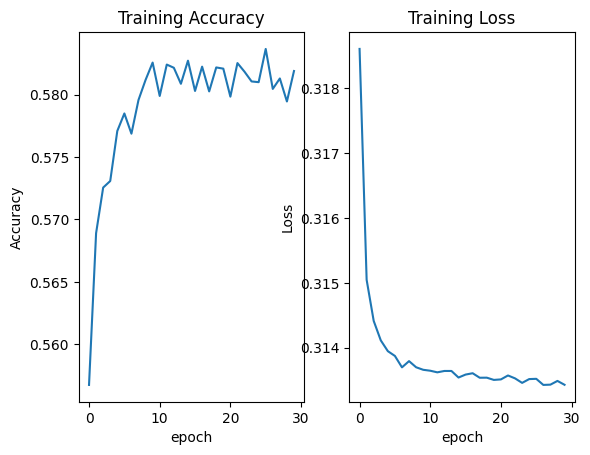

In [18]:
plotLossAndAcc(model1_history)

In [19]:
images_gray_test = images_gray[:250, :, :]

In [20]:
prediction1 = model.predict(images_gray_test)

8/8 [==============================] - 10s 948ms/step


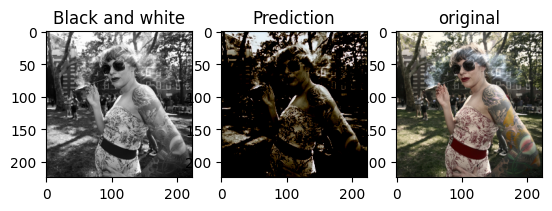

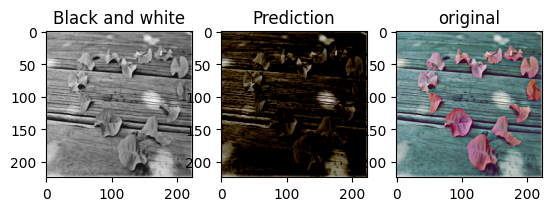

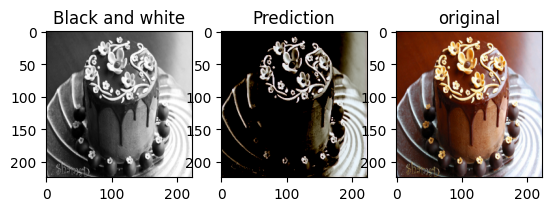

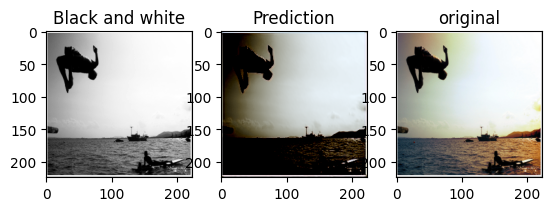

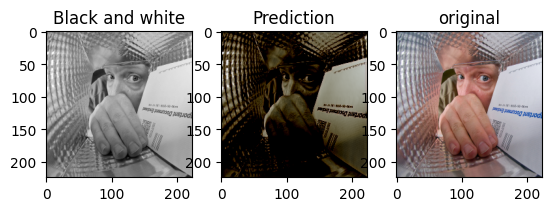

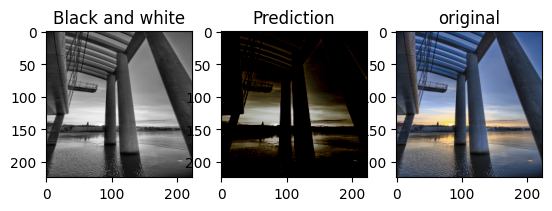

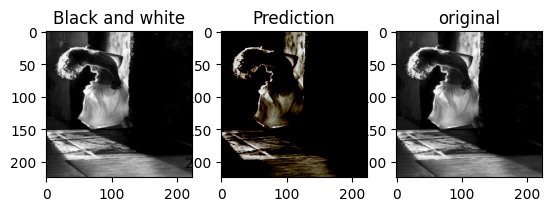

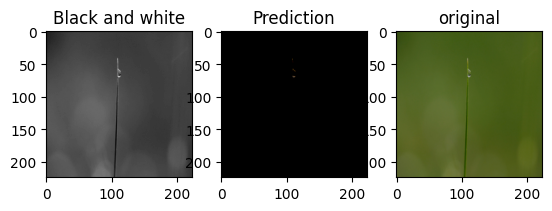

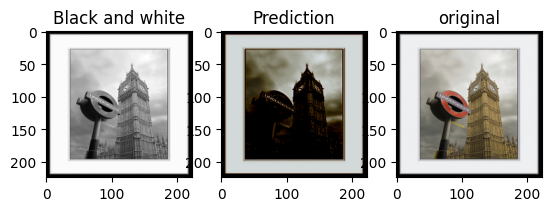

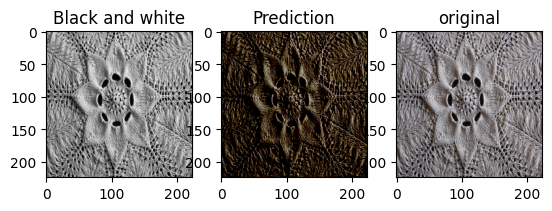

In [21]:
compareImages(0, 10, prediction1, init_images_gray, images_rgb)